Import des libraires

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob

# Import du jeu de données

In [3]:
files_to_load = glob.glob('../data/*.txt')
dvf_raw = pd.concat([pd.read_csv(file,sep="|", decimal=',') for file in files_to_load])
df_reference_departement_raw = pd.read_csv("../reference/departements-region.csv",delimiter=",")

C:\Users\maelp\AppData\Local\Temp\ipykernel_2900\1324177573.py:2: DtypeWarning: Columns (18,23,24,26,28,41) have mixed types. Specify dtype option on import or set low_memory=False.
  dvf_raw = pd.concat([pd.read_csv(file,sep="|", decimal=',') for file in files_to_load])


# purification des données

In [4]:
dvf_raw['Date mutation'] = pd.to_datetime(dvf_raw['Date mutation'], format='%d/%m/%Y')
dvf_raw['Nature mutation'] = dvf_raw['Nature mutation'].astype('category')

colonnes_a_garder = [
    'Date mutation', 
    'Nature mutation', 
    'Valeur fonciere',
    'Commune',
    'Code departement',
    'Surface terrain',
    'Surface reelle bati'
    ]

df_vf_raw = dvf_raw.drop(columns=[col for col in dvf_raw.columns if col not in colonnes_a_garder])
pd.set_option('display.float_format', '{:.2f}'.format)

df_vf_raw['prix metre carre'] = df_vf_raw['Valeur fonciere'] / df_vf_raw['Surface reelle bati']

### Ajout d'un zéro dans le code département pour Merger

In [5]:
def updateCode(code : object) -> str:
    return str.zfill("{0}".format(code),2)

df_vf_raw['Code departement']=df_vf_raw['Code departement'].apply(updateCode)

df_dvf_region = df_vf_raw.merge(df_reference_departement_raw, how='left',left_on='Code departement', right_on='num_dep')

In [6]:
df_dvf_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803885 entries, 0 to 3803884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Date mutation        datetime64[ns]
 1   Nature mutation      category      
 2   Valeur fonciere      float64       
 3   Commune              object        
 4   Code departement     object        
 5   Surface reelle bati  float64       
 6   Surface terrain      float64       
 7   prix metre carre     float64       
 8   num_dep              object        
 9   dep_name             object        
 10  region_name          object        
dtypes: category(1), datetime64[ns](1), float64(4), object(5)
memory usage: 293.8+ MB


- tier par vente
- ramener le prix au mètre carré (surface terrain pour les maisons)

In [11]:

moyenne_prix_departement = df_dvf_region.groupby('Code departement')['prix metre carre'].mean()
nombre_vente_departement = df_dvf_region.groupby('Code departement')['Valeur fonciere'].count()
nom_departement = df_dvf_region.groupby('Code departement')['dep_name']
nombre_vente_region = df_dvf_region.groupby('region_name')['Valeur fonciere'].count()
nombre_vente_region = nombre_vente_region.reset_index()
nombre_vente_region.rename(columns={"Valeur fonciere": "nombre_vente"},inplace=True)
fusion = pd.merge(moyenne_prix_departement, nombre_vente_departement, left_index=True, right_index=True)
fusion = fusion.merge(df_reference_departement_raw, how='left',left_on='Code departement', right_on='num_dep')
fusion.rename(columns={"Valeur fonciere_x": "moyenne_prix", "Valeur fonciere": "nombre_vente"},inplace=True)
fusion.reset_index(inplace=True)

# Affichage du résultat
#print(moyenne_prix_departement)
#print(nombre_vente_departement)
#print(nombre_vente_region)
print(fusion)


    index  prix metre carre  nombre_vente num_dep                 dep_name   
0       0               NaN         35626      01                      Ain  \
1       1               NaN         34632      02                    Aisne   
2       2               NaN         31080      03                   Allier   
3       3               NaN          5915      04  Alpes-de-Haute-Provence   
4       4               NaN          9123      05             Hautes-Alpes   
..    ...               ...           ...     ...                      ...   
92     92               NaN         49760      95               Val-d'Oise   
93     93               NaN          2996     971               Guadeloupe   
94     94               NaN          5433     972               Martinique   
95     95               NaN          5191     973                   Guyane   
96     96               NaN         13282     974               La Réunion   

                   region_name  
0         Auvergne-Rhône-Alpes

In [12]:
colonne_tri = 'nombre_vente'
df_trie_asc = fusion.sort_values(by=colonne_tri)[:5]
df_trie_desc = fusion.sort_values(by=colonne_tri)[-5:]
print(df_trie_asc)


    index  prix metre carre  nombre_vente num_dep                 dep_name   
93     93               NaN          2996     971               Guadeloupe  \
95     95               NaN          5191     973                   Guyane   
94     94               NaN          5433     972               Martinique   
3       3               NaN          5915      04  Alpes-de-Haute-Provence   
29     29               NaN          6501      2B              Haute-Corse   

                   region_name  
93                  Guadeloupe  
95                      Guyane  
94                  Martinique  
3   Provence-Alpes-Côte d'Azur  
29                       Corse  


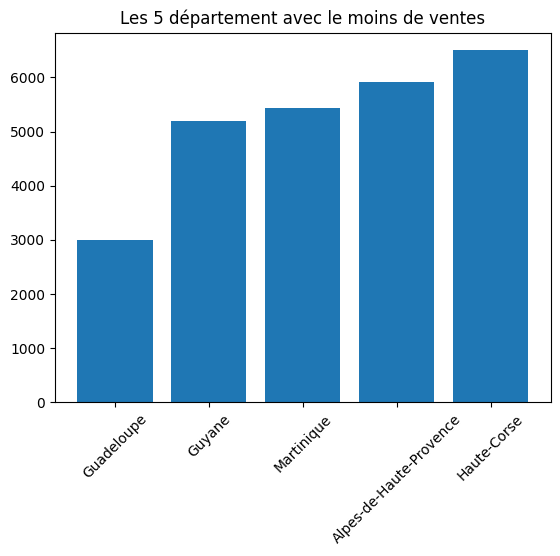

In [13]:
plt.bar(df_trie_asc['dep_name'],df_trie_asc['nombre_vente'])

# Ajouter un titre
plt.title('Les 5 département avec le moins de ventes')
# Afficher le diagramme
plt.xticks(rotation=45)
plt.show()

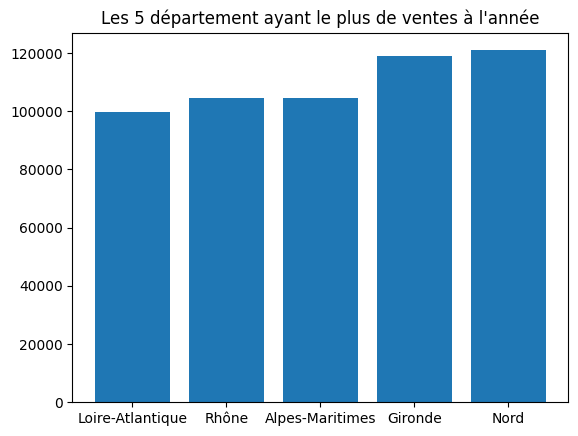

In [14]:
plt.bar(df_trie_desc['dep_name'],df_trie_desc['nombre_vente'])

# Ajouter un titre
plt.title('Les 5 département ayant le plus de ventes à l\'année')
# Afficher le diagramme
plt.show()

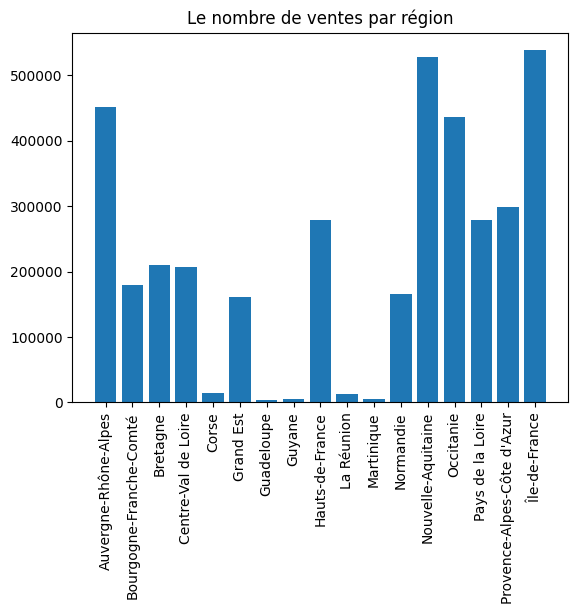

In [15]:
plt.bar(nombre_vente_region['region_name'],nombre_vente_region['nombre_vente'])

# Ajouter un titre
plt.title('Le nombre de ventes par région')
# Afficher le diagramme
plt.xticks(rotation=90)
plt.show()